# C1 - Introduction to Human and Computer Vision
## Week 2 - Draft Notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import matplotlib.pyplot as plt

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week2')
os.chdir(BASE_PATH)
BASE_PATH

'c:\\Users\\Usuario\\Documents\\MCsComputerVision\\C1\\Team5\\week2'

### Load datasets

In [5]:
from src.image_dataset import ImageDataset, ColorSpace
import platform

DATA_DIRECTORY = '../data'

# Load the Cropped Dataset (QueryDataset) and Background Dataset (BGDataset)
BDDataset = ImageDataset(f'{DATA_DIRECTORY}/BBDD', colorspace=ColorSpace.CieLab, interval=10)
QueryDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w1', colorspace=ColorSpace.CieLab, interval=10)
BGDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd2_w2', colorspace=ColorSpace.CieLab, interval=10)

### Task 1 - Block and hierarchical histograms

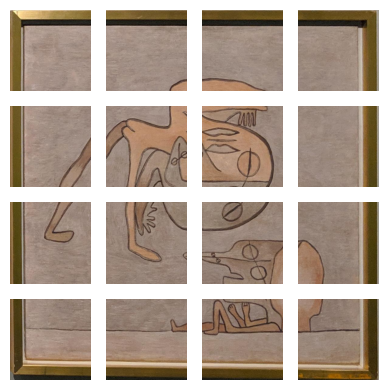

In [7]:
import importlib
import src.image

# Reload after making changes
importlib.reload(src.image) 
from src.image import Image

image = Image(QueryDataset.images[0].path)

ROWS = 4
COLUMNS = 4
image_blocks = image.divide_img_into_blocks(ROWS, COLUMNS)

fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(COLUMNS, ROWS))
    
for i in range(ROWS):
    for j in range(COLUMNS):
        axes[i, j].imshow(image_blocks[i][j])
        axes[i, j].axis('off') 

plt.tight_layout()
plt.show()

In [8]:
image.compute_histogram_block_descriptor(7, image_blocks, ROWS, COLUMNS)

In [9]:
def get_histograms_per_block(path):
    """
    """
    image = Image(path)
    image_blocks = image.divide_img_into_blocks(ROWS, COLUMNS)
    image.compute_histogram_block_descriptor(7, image_blocks, ROWS, COLUMNS)

    return image.histogram_descriptor

image1_descriptors = get_histograms_per_block(QueryDataset.images[0].path)
image2_descriptors = get_histograms_per_block(QueryDataset.images[1].path)


#### Spatial Pyramid Representation

### Task 2 - Evaluate retrieval results

In [10]:
from typing import Dict, List
import numpy as np
from src.metrics import DistanceType, SimilarityType, apk

def compute_results_by_similarity(
      bdd_dataset: ImageDataset,
      query_dataset: ImageDataset,
      ground_truth: List[List[int]],
      similarity_type: SimilarityType = SimilarityType.histogram_intersection
   ) -> Dict:

   result = []
   similarities_result = []
   for image in query_dataset:
      similarities_list = []
      for image2 in bdd_dataset:
        similarities = image.compute_similarity(image2, type=similarity_type)
        similarity = np.mean(similarities)
        similarities_list.append(similarity)
      top_k = np.argsort(similarities_list)[-5:][::-1]

      result.append([bdd_dataset[i].index for i in top_k])
      similarities_result.append([similarities_list[i] for i in top_k])
   
   return {
      'apk1': [apk(a,p,1) for a,p in zip(ground_truth, result)],
      'apk5': [apk(a,p,5) for a,p in zip(ground_truth, result)],
      'similarities': similarities_result
   }

#### Block-based Histograms

In [11]:
import pickle

with open(f'{DATA_DIRECTORY}/qsd1_w1/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

In [ ]:
result = {}
metric = SimilarityType.bhattacharyya
interval = 7

importlib.reload(src.image) 

res = compute_results_by_similarity(
    BDDataset, QueryDataset, ground_truth, metric,
)

result[metric.__name__] = {
    'mapk1': np.mean(res['apk1']),
    'mapk5': np.mean(res['apk5'])
}

print(result)

#### Spatial Pyramid Representation

### Task 3 - Background removal

#### Plot Original / Groundtruth / Obtained Mask

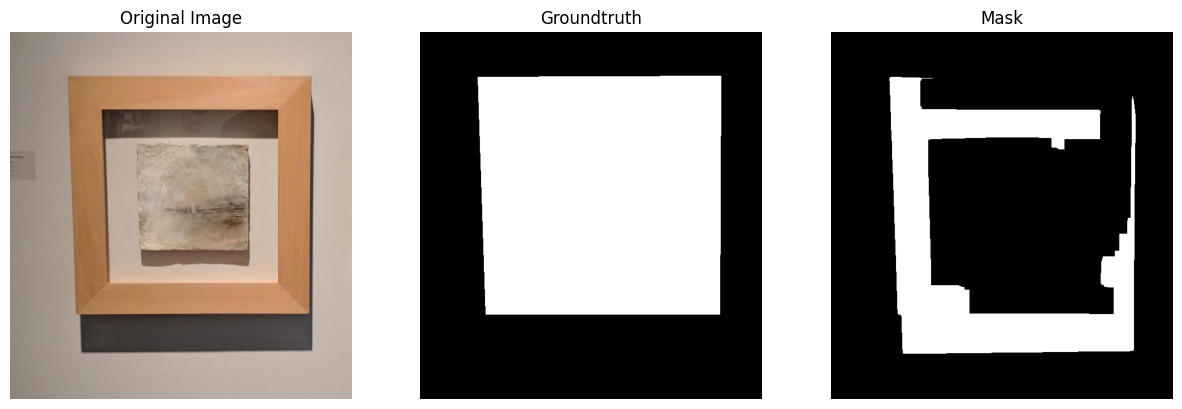

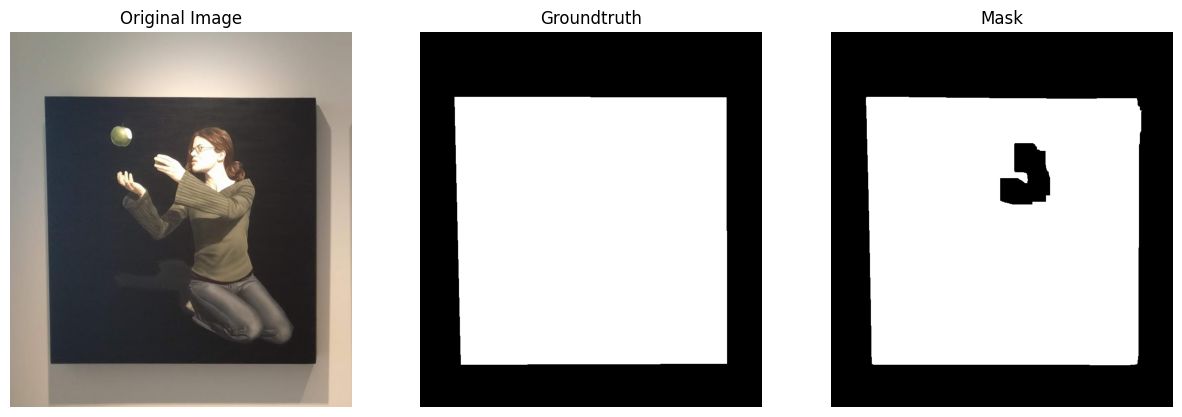

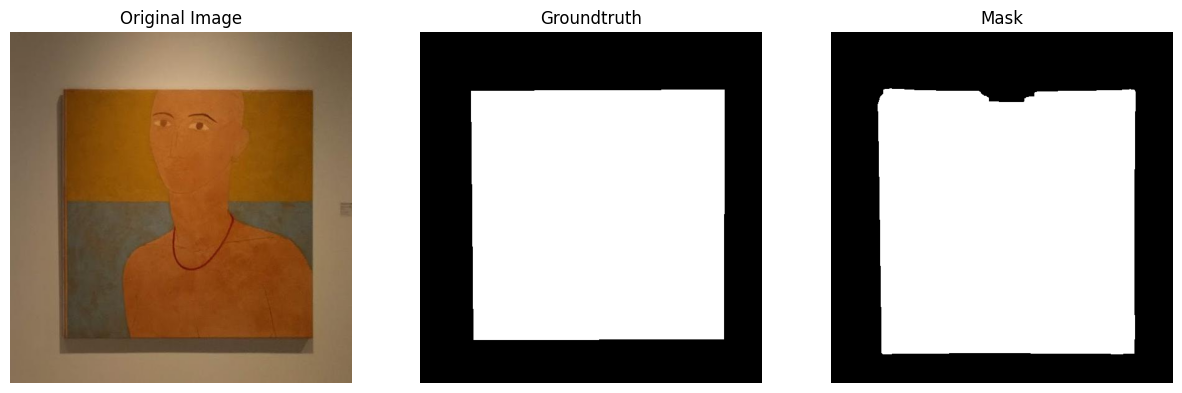

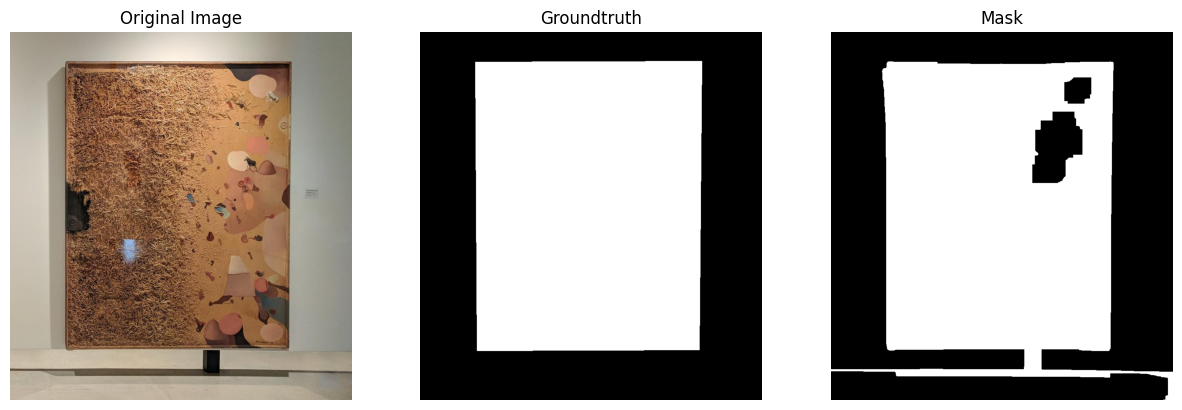

In [7]:
import importlib
import cv2
import src.background_removal

# Reload after making changes
importlib.reload(src.background_removal) 
from src.background_removal import get_mask_and_foreground

background_files = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w2') if f.endswith('.png')]

# Loop will need to be changed to len(background_files) --> for i in range(0, len(background_files))
for i in range(0, 4):
    image = cv2.cvtColor(BGDataset.images[i].original_image, cv2.COLOR_BGR2RGB)

    # Original Image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Groundtruth
    ground_truth = os.path.join(f'{DATA_DIRECTORY}/qsd2_w2', background_files[i])
    ground_truth = cv2.imread(ground_truth)
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth)
    plt.title('Groundtruth')
    plt.axis('off')

    # Obtained Mask
    foreground, mask = get_mask_and_foreground(image)
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

#### Save masks

In [91]:
FOREGROUND_DIR = "data_results/foregrounds"
MASK_DIR = "data_results/masks"
for path in [FOREGROUND_DIR, MASK_DIR]:
    if not os.path.exists(path):
        os.makedirs(path)

def get_image_filename(path):
    """
    Returns image filename (e.g. 00000, 00001, ...)
    """
    base_name = os.path.basename(path)
    file_name = os.path.splitext(base_name)[0]
    return file_name

# Save Foreground and Masks results
for i in range(0, len(background_files)):
    image = cv2.cvtColor(BGDataset.images[i].original_image, cv2.COLOR_BGR2RGB)
    filename = get_image_filename(BGDataset.images[i].path)

    foreground, mask = get_mask_and_foreground(image)
    foreground_path = os.path.join(FOREGROUND_DIR, f"{filename}.png")
    mask_path = os.path.join(MASK_DIR, f"{filename}.png")

    # Save the foreground and mask
    cv2.imwrite(foreground_path, foreground)
    cv2.imwrite(mask_path, mask)

### Task 4 - Background removal evaluation

In [8]:
import pandas as pd
import src.background_removal

# Reload after making changes
importlib.reload(src.background_removal) 
from src.background_removal import evaluate_masks

# First directory needs to be updated!
precision, recall, f1_score = evaluate_masks(f'{MASK_DIR}', f'{DATA_DIRECTORY}/qsd2_w2')

results = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [precision, recall, f1_score]
})
print(results)

NameError: name 'MASK_DIR' is not defined

### Task 5 - Retrieval

### Task 6 - .pkl results generation